# Investigating expression and association to survival of '*dark*' kinases in The Cancer Genome Atlas (TCGA) data

### Overview
This Jupyter Notebook contains an analysis of the expression of *dark* kinases and its relationship to patient survival across multiple tumor types profiled by The Cancer Genome Atlas (TCGA) consortium.

The analysis focuses on three *dark* genes, **PKMYT1, NEK4, **and** PKN3**, identified as part of a larger cluster of genes involved in the regulation of cell cycle.  Link to the Jupyter Notebook containing the analysis is available [here](http://nbviewer.jupyter.org/github/MaayanLab/KMC_2017/blob/master/notebooks/Inter_Dark_Kinase_Function_from_Clustering.ipynb).

Below is a walkthrough of the analysis, with corresponding Python and R code.

In [1]:
# Import python modules
import os, glob
import pandas as pd
import numpy as np
import rpy2

# Import R
%load_ext rpy2.ipython

# Change directory
os.chdir('/Users/Denis/Documents/Projects/idg/idg-analysis/tcga-data/')

### 1. Differential Expression Analysis
In the first section, we run a differential gene expression analysis comparing solid tumor samples (sample type 01) to matched normal tissue samples (sample type 11).  As an example, we will use the TCGA dataset for Kidney Renal Clear Cell Carcinoma (tumor code KIRC).

First, we read the raw count matrix in a pandas dataframe.

In [2]:
# Read raw counts
rawcountFile = 'TCGA-KIRC/TCGA-KIRC-counts.txt'
rawcountDataframe = pd.read_table(rawcountFile, index_col='gene_symbol')
rawcountDataframe.head()

,TCGA-3Z-A93Z-01,TCGA-6D-AA2E-01,TCGA-A3-3306-01,TCGA-A3-3307-01,TCGA-A3-3308-01,TCGA-A3-3311-01,TCGA-A3-3313-01,TCGA-A3-3316-01,TCGA-A3-3317-01,TCGA-A3-3319-01,...,TCGA-G6-A5PC-01,TCGA-G6-A8L6-01,TCGA-G6-A8L7-01,TCGA-G6-A8L8-01,TCGA-GK-A6C7-01,TCGA-MM-A563-01,TCGA-MM-A564-01,TCGA-MM-A84U-01,TCGA-MW-A4EC-01,TCGA-T7-A92I-01
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,21,7,3,6,11,12,4,12,24,29,...,6,4,24,3,35,16,15,13,26,88
A1BG-AS1,77,23,31,40,37,41,22,40,87,185,...,12,27,41,33,175,64,24,49,91,421
A1CF,983,293,1694,4320,1685,5080,407,891,607,2684,...,399,648,5,924,5291,827,115,229,1634,12
A2M,59145,22413,30294,80336,94523,75523,34189,54645,96664,31935,...,17385,52267,12928,67769,173129,80934,70737,62825,62973,17784
A2M-AS1,69,140,182,84,69,137,195,151,71,228,...,14,37,30,94,55,84,152,77,85,234


Second, we create an annotation dataframe containing the sample type label for each sample - either 01 (for tumor samples) or 11 (for matched normal tissue samples).

In [18]:
# Create sample annotation dataframe
annotationDataframe = pd.DataFrame.from_dict([{'sample_id': x, 'sample_type': x.split('-')[-1]} for x in rawcountDataframe.columns]).set_index('sample_id')

# Filter by selecting only sample types 01 (solid tumor) and 11 (matched normal tissue)
annotationDataframe = annotationDataframe[annotationDataframe['sample_type'].isin(['01', '11'])]
rawcountDataframe = rawcountDataframe[annotationDataframe.index]

# Display 5 rows
annotationDataframe.sort_values('sample_type', ascending=False).iloc[70:75]

,sample_type
sample_id,
TCGA-B0-5697-11,11
TCGA-B0-5705-11,11
TCGA-CJ-4881-01,01
TCGA-BP-5187-01,01
TCGA-BP-5189-01,01


We now run a differential expression analysis using the raw count and the annotation dataframes, using the DESeq2 R package (Love et al., 2014).

In [ ]:
%%R -i annotationDataframe,rawcountDataframe
# Load library
library(DESeq2)

# R automatically replaces - with . in the column names, this line changes it back
colnames(rawcountDataframe) <- gsub('.', '-', colnames(rawcountDataframe), fixed=TRUE)

# Prepare DESeq2 dataset object
dds <- DESeqDataSetFromMatrix(countData = countDataframe, colData = annotationDataframe, design = as.formula(design))

# Filter lowly expressed genes
dds <- dds[rowSums(counts(dds)) > 1,]

# Run differential expression analysis
dds <- DESeq(dds)

# Get results
res <- as.data.frame(results(dds))

As the process is computationally intensive, here we load the results of a pre-run analysis using the code above.

In [4]:
# Load pre-run results for KIRC
%R res <- read.table('TCGA-KIRC/deseq/TCGA-KIRC-deseq-01v11.txt', sep='\t', header=TRUE, row.names='gene_symbol'); head(res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,15.687438,-1.043239,0.142423,-7.324938,2.390084e-13,8.628567e-13
A1BG-AS1,67.404522,-0.546551,0.101561,-5.381527,7.385658e-08,1.841424e-07
A1CF,2370.832020,0.032763,0.211810,0.154681,8.770727e-01,8.980017e-01
A2M,92312.518831,-0.258937,0.093910,-2.757300,5.828083e-03,9.354101e-03
A2M-AS1,134.446790,0.321090,0.077046,4.167505,3.079524e-05,6.212327e-05
A2ML1,10.732924,-1.160086,0.190441,-6.091569,1.118092e-09,3.194184e-09


We now explore the results of the differential expression analysis across all TCGA tumor types containing at least 5 of each solid tumor samples (sample type 01) and matched normal tissue samples (sample type 11).  To do this, we write a function to display relevant results in a dataframe for a given gene: in this case, **PKMYT1**.

In [19]:
# Load all differential expression results
deseqData = {os.path.basename(x).replace('-deseq', '')[:-len('.txt')]: pd.read_table(x, index_col='gene_symbol') for x in glob.glob('*/deseq/*01v11.txt')}

# Define function to print results given a gene symbol
def printDeseqResults(geneSymbol, deseqData=deseqData):
    deResultDataframe = pd.DataFrame({x.replace('v', '_v_').replace('01','primary_tumor').replace('11', 'normal').replace('02','recurrent_tumor').replace('06', 'metastasis'): deseqData[x].loc[geneSymbol, ['baseMean', 'log2FoldChange', 'pvalue', 'padj']] for x in deseqData.keys()}).T.sort_values('pvalue')
    deResultDataframe['log2FoldChange'] = -deResultDataframe['log2FoldChange']
    return deResultDataframe

# Print results for PKMYT1
printDeseqResults('PKMYT1')

,baseMean,log2FoldChange,pvalue,padj
TCGA-BRCA-primary_tumor_v_normal,1125.421081,3.967015,1.709649e-260,5.014229e-257
TCGA-LUSC-primary_tumor_v_normal,1332.141671,4.094435,4.645349e-230,2.650636e-227
TCGA-UCEC-primary_tumor_v_normal,798.382273,3.965970,3.406796e-112,1.319257e-108
TCGA-KIRC-primary_tumor_v_normal,140.198914,2.933729,6.650384e-100,7.370647e-98
TCGA-LUAD-primary_tumor_v_normal,531.029110,2.982183,8.349495e-86,1.480486e-83
TCGA-LIHC-primary_tumor_v_normal,258.068135,3.122725,3.400624e-69,1.768112e-66
TCGA-KIRP-primary_tumor_v_normal,172.943277,3.304924,1.381961e-49,3.251852e-47
TCGA-HNSC-primary_tumor_v_normal,2063.650498,1.910592,1.683250e-49,4.226049e-47
TCGA-COAD-primary_tumor_v_normal,1196.534170,1.924343,2.384952e-44,9.394223e-43
TARGET-WT-primary_tumor_v_normal,1816.322314,3.735869,1.502884e-39,1.965653e-37


Strikingly, PKMYT1 is *significantly overexpressed* at FDR < 10<sup>-7</sup> and below in *all* of the profiled tumor types.  We now display the differential expression results as boxplots.

In [6]:
%%R
# Define function to print differential expression boxplots
plotDifferentialExpression <- function(tumorType, geneSymbol, expressionData) {
    
    fpkmDataframe <- expressionData[[tumorType]]

    geneFpkmDataframe <- as.data.frame(t(fpkmDataframe[geneSymbol,]))

    geneFpkmDataframe$sample_type <- sapply(rownames(geneFpkmDataframe), function(x) strsplit(x, '-')[[1]][4])

    sampleNames <- c('01' = 'Solid Tumor', '11' = 'Normal Tissue')

    geneFpkmDataframe <- geneFpkmDataframe[geneFpkmDataframe$sample_type %in% names(sampleNames),]

    geneFpkmDataframe$sample_name <- sampleNames[geneFpkmDataframe$sample_type]

    colnames(geneFpkmDataframe)[1] <- 'expression'

    boxplot(expression ~ sample_name, data=geneFpkmDataframe, log='y', xlab='', ylab='Expression (FPKM)', col=c('#fed976','#fc4e2a'), main=paste(tumorType));
}

In [7]:
%%R
# Read expression data for selected tumor types
tumorTypes <- c('TCGA-LUSC', 'TCGA-LUAD', 'TCGA-COAD', 'TCGA-KIRC', 'TCGA-BRCA')

# For plotting purposes, here we load the FPKM (Fragments per Kilobase per Million reads mapped) expression levels
expressionData <- sapply(tumorTypes, function(x) read.table(paste0(x, '/', x, '-fpkm-uq.txt'), row.names='gene_symbol', header=TRUE, sep='\t', check.names=FALSE))

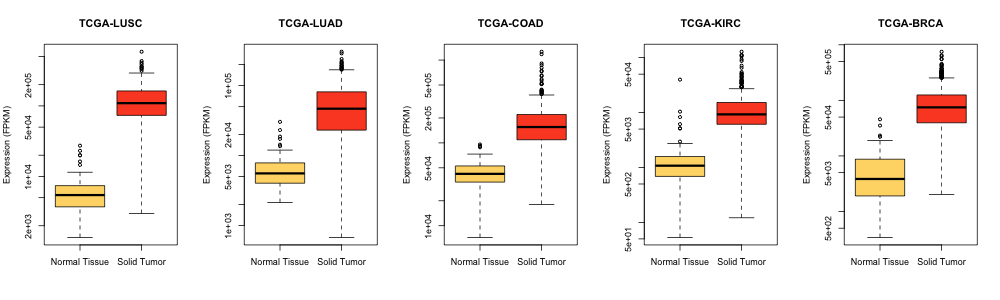

In [20]:
%%R -h 300 -w 1000
# Plot differential expression
par(mfrow=c(1, length(tumorTypes)), cex=0.75)
for (tumorType in tumorTypes) {
    plotDifferentialExpression(tumorType, 'PKMYT1', expressionData)
}

### Survival Analysis
In the second part of the analysis, we explore the relationship between patient survival and the relative expression of PKMYT1.  To achieve this, we take advantage of the clinical data profiled by TCGA.  First, we need the gene expression dataframes.  In this case, in order to adjust for different library sizes across RNA-seq samples, we load FPKM (Fragments Per Kilobase of transcript per Million reads mapped) expression matrix instead of the raw counts matrix.  Again, we use Kidney Renal Clear Cell Carcinoma (KIRC) as an example.

In [21]:
# Read FPKM expression
fpkmFile = 'TCGA-KIRC/TCGA-KIRC-fpkm-uq.txt'
fpkmDataframe = pd.read_table(fpkmFile, index_col='gene_symbol')
fpkmDataframe.head()

,TCGA-3Z-A93Z-01,TCGA-6D-AA2E-01,TCGA-A3-3306-01,TCGA-A3-3307-01,TCGA-A3-3308-01,TCGA-A3-3311-01,TCGA-A3-3313-01,TCGA-A3-3316-01,TCGA-A3-3317-01,TCGA-A3-3319-01,...,TCGA-G6-A5PC-01,TCGA-G6-A8L6-01,TCGA-G6-A8L7-01,TCGA-G6-A8L8-01,TCGA-GK-A6C7-01,TCGA-MM-A563-01,TCGA-MM-A564-01,TCGA-MM-A84U-01,TCGA-MW-A4EC-01,TCGA-T7-A92I-01
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,3.480835e+03,9.996447e+02,4.165054e+02,7.011954e+02,1.234243e+03,1.007994e+03,3.806718e+02,2.000005e+03,2.119212e+03,2.600500e+03,...,1.243981e+03,7.423809e+02,6.777165e+03,3.646387e+02,2.867611e+03,2.110998e+03,2.452519e+03,1.920197e+03,2.772433e+03,6982.533193
A1BG-AS1,1.830606e+04,4.711026e+03,6.173068e+03,6.704831e+03,5.954559e+03,4.939701e+03,3.002987e+03,9.562022e+03,1.101850e+04,2.379417e+04,...,3.568485e+03,7.187379e+03,1.660583e+04,5.753014e+03,2.056507e+04,1.211122e+04,5.628237e+03,1.038098e+04,1.391775e+04,47912.898220
A1CF,6.797068e+04,1.745498e+04,9.811079e+04,2.106083e+05,7.886999e+04,1.780100e+05,1.615806e+04,6.194859e+04,2.235918e+04,1.004027e+05,...,3.450956e+04,5.017020e+04,5.889939e+02,4.685085e+04,1.808398e+05,4.551740e+04,7.843736e+03,1.411048e+04,7.268482e+04,397.205816
A2M,6.151771e+06,2.008472e+06,2.639211e+06,5.891367e+06,6.655235e+06,3.980834e+06,2.041716e+06,5.715026e+06,5.356068e+06,1.796982e+06,...,2.261806e+06,6.087128e+06,2.290795e+06,5.168811e+06,8.901027e+06,6.700651e+06,7.257480e+06,5.823082e+06,4.213666e+06,885478.158205
A2M-AS1,2.090179e+04,3.653811e+04,4.617864e+04,1.794062e+04,1.414905e+04,2.103138e+04,3.391531e+04,4.599356e+04,1.145756e+04,3.736492e+04,...,5.304702e+03,1.254986e+04,1.548205e+04,2.088044e+04,8.235412e+03,2.025432e+04,4.541874e+04,2.078564e+04,1.656445e+04,33932.557157


Second, we need the processed survival matrices for the corresponding patients.

In [22]:
# Read survival matrix
survivalFile = 'TCGA-KIRC/TCGA-KIRC-survival.txt'
survivalDataframe = pd.read_table(survivalFile, index_col='patient_barcode')
survivalDataframe['last_checkup'] = [x if np.isnan(y) else y for x, y in survivalDataframe[['days_to_death', 'days_to_last_followup']].as_matrix()]
survivalDataframe.iloc[10:20,]

,vital_status,days_to_death,days_to_last_followup,last_checkup
patient_barcode,,,,
TCGA-BP-4352,Dead,344.0,NaN,344.0
TCGA-BP-4992,Alive,NaN,501.0,501.0
TCGA-BP-5174,Alive,NaN,2257.0,2257.0
TCGA-B0-4845,Dead,1986.0,NaN,1986.0
TCGA-3Z-A93Z,Alive,NaN,4.0,4.0
TCGA-BP-4983,Alive,NaN,1413.0,1413.0
TCGA-A3-3373,Alive,NaN,334.0,334.0
TCGA-CJ-5684,Alive,NaN,2231.0,2231.0
TCGA-CZ-4861,Dead,446.0,NaN,446.0


We now investigate the relationship between patient survival and the relative expression of PKMYT1.  To achieve this, we split the patients in three groups, according to the ranked expression of PKMYT1.  We then calculate differential survival between the three groups by applying a log rank test, using the survival R package (Therneau, 2015).

In [83]:
# Define function to split samples in three groups, according to the expression of a specified gene,
# and plot Kaplan-Meier curves of them.  Differential survival is calculated with the R package survival.

%R library(survival)
    
def plotSurvivalAssociation(geneSymbol, tumorType):
    
    # Read dataframes
    fpkmDataframe = pd.read_table('%(tumorType)s/%(tumorType)s-fpkm-uq.txt' % locals(), index_col='gene_symbol')
    survivalDataframe = pd.read_table('%(tumorType)s/%(tumorType)s-survival.txt' % locals(), index_col='patient_barcode')
    survivalDataframe['last_checkup'] = [x if np.isnan(y) else y for x, y in survivalDataframe[['days_to_death', 'days_to_last_followup']].as_matrix()]
    
    # Filter columns
    cols = [x for x in fpkmDataframe.columns if x.split('-')[-1]=='01']
    fpkmDataframeSubset = fpkmDataframe[cols]

    # Fix column labels
    fpkmDataframeSubset.columns = ['-'.join(x.split('-')[:3]) for x in fpkmDataframeSubset.columns]

    # Aggregate
    fpkmDataframeSubset = fpkmDataframeSubset.T.reset_index().groupby('index').mean().T

    # Get common patients
    commonPatients = list(set(fpkmDataframeSubset.columns).intersection(set(survivalDataframe.index)))
    fpkmDataframeSubset = fpkmDataframeSubset[commonPatients]

    # Split samples
    split_cols = np.array_split(fpkmDataframeSubset.loc[geneSymbol].to_frame().sort_values(geneSymbol).index.tolist(), 3)
    groupDataframe = pd.DataFrame([[x, i] for i in range(len(split_cols)) for x in split_cols[i]], columns=['patient_barcode','group']).set_index('patient_barcode')

    # Check order
    survivalDataframeSubset = survivalDataframe.loc[groupDataframe.index, ['vital_status', 'last_checkup']]
    survivalDataframeSubset['event'] = [x=='Dead' for x in survivalDataframeSubset['vital_status']]
    
    # Get plot dataframe
    plotDataframe = groupDataframe.merge(fpkmDataframeSubset.T, left_index=True, right_index=True, how='inner')[['group', geneSymbol]].rename(columns={geneSymbol: 'expression'})

    # Run R
    %R -i survivalDataframeSubset,groupDataframe,geneSymbol,tumorType,plotDataframe
    %R survivalObj <- Surv(time=survivalDataframeSubset$last_checkup, event=survivalDataframeSubset$event);
    %R sfit <- survfit(survivalObj ~ groupDataframe$group);
    %R sdiff <- survdiff(survivalObj ~ groupDataframe$group);
    %R p <- 1 - pchisq(sdiff$chisq, df=length(sdiff$n) - 1);
    %R colors <- c('#fed976','#fc4e2a','#bd0026')
    %R groupLabels <- c('Low', 'Medium', 'High')
    %R -h 500 -w 1000 par(mfrow=c(1,2)); plot(sfit, lwd=3, xlab="days", ylab="Percent Survival", col=colors, main=paste('Association between survival and', as.character(geneSymbol),'in',as.character(tumorType)));grid(col="grey"); mtext(paste("p=",format.pval(p,digits=3)," (Samples: ",nrow(survivalObj)," - Deaths: ",sum(survivalObj[,2], na.rm=TRUE),")",sep=""), padj=-0.75); legend("bottomleft",col=colors,legend=groupLabels,lty=1,lwd=3,bg="white"); boxplot(expression ~ group, data=plotDataframe, col=colors, log='y', names=groupLabels, ylab='Expression (FPKM)', main=paste(geneSymbol, 'expression levels by group'));

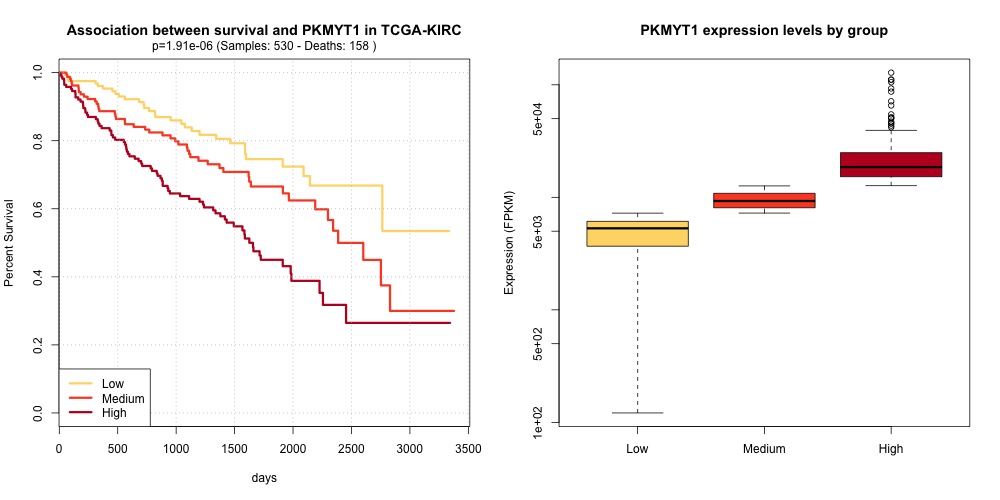

In [84]:
plotSurvivalAssociation('PKMYT1', 'TCGA-KIRC')

The analysis indicates that in Kidney Renal Clear Cell Carcinoma patients with higher expression of PKMYT1 tend to have poorer prognosis and significantly reduced survival times, when compared to patients with lower expression of the gene.  The same is true for Adrenocortical Carcinoma (ACC), as seen below.

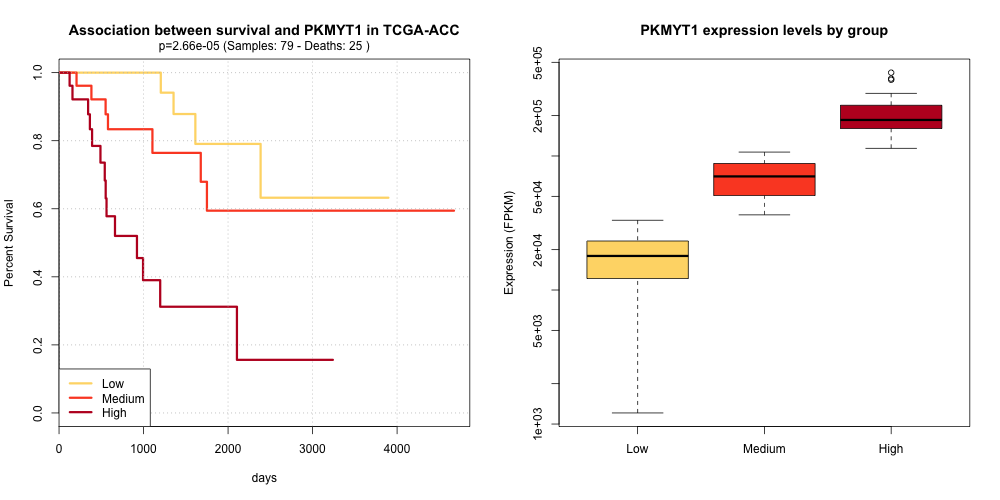

In [85]:
plotSurvivalAssociation('PKMYT1', 'TCGA-ACC')

We now extend the analysis to the other two genes identified, NEK4 and PKN3.

In [86]:
printDeseqResults('NEK4')

,baseMean,log2FoldChange,pvalue,padj
TCGA-KIRC-primary_tumor_v_normal,860.396528,-0.940015,8.494031e-58,2.073271e-56
TARGET-WT-primary_tumor_v_normal,2473.865934,0.906614,1.154873e-07,8.336234e-07
TCGA-HNSC-primary_tumor_v_normal,654.304074,-0.466008,2.007813e-07,8.633955e-07
TCGA-THCA-primary_tumor_v_normal,1459.108672,-0.322987,1.344839e-06,4.382854e-06
TCGA-COAD-primary_tumor_v_normal,690.137862,0.316339,5.295948e-06,1.448178e-05
TCGA-KIRP-primary_tumor_v_normal,860.492387,-0.465011,7.416041e-05,2.135115e-04
TCGA-STAD-primary_tumor_v_normal,1524.838186,0.366921,1.271008e-04,4.562108e-04
TCGA-LUAD-primary_tumor_v_normal,973.883837,0.204694,8.253227e-04,1.623749e-03
TCGA-BRCA-primary_tumor_v_normal,1556.101119,0.197563,8.428046e-04,1.530091e-03
TCGA-CHOL-primary_tumor_v_normal,577.900261,-0.656696,2.342217e-03,6.389401e-03


Contrary to PKMYT1, **NEK4** shows *varying patterns of differential expression* across TCGA tumor types - it is significantly overexpressed in Wilms' Tumor (WT, the most common type of kidney cancer in children), Colon Adenocarcinoma (COAD), and Stomach Adenocarcinoma (STAD), among others; and significantly underexpressed in Kidney Renal Clear Cell Carcinoma (KIRC), Head and Neck Squamous Cell Carcinoma (HNSC), and Thyroid Carcinoma (THCA), among others.

In [87]:
%%R
# Read expression data for selected tumor types
tumorTypes <- c('TARGET-WT', 'TCGA-COAD', 'TCGA-STAD', 'TCGA-KIRC', 'TCGA-HNSC', 'TCGA-THCA')

# For plotting purposes, here we load the FPKM (Fragments per Kilobase per Million reads mapped) expression levels
expressionData <- sapply(tumorTypes, function(x) read.table(paste0(x, '/', x, '-fpkm-uq.txt'), row.names='gene_symbol', header=TRUE, sep='\t', check.names=FALSE))

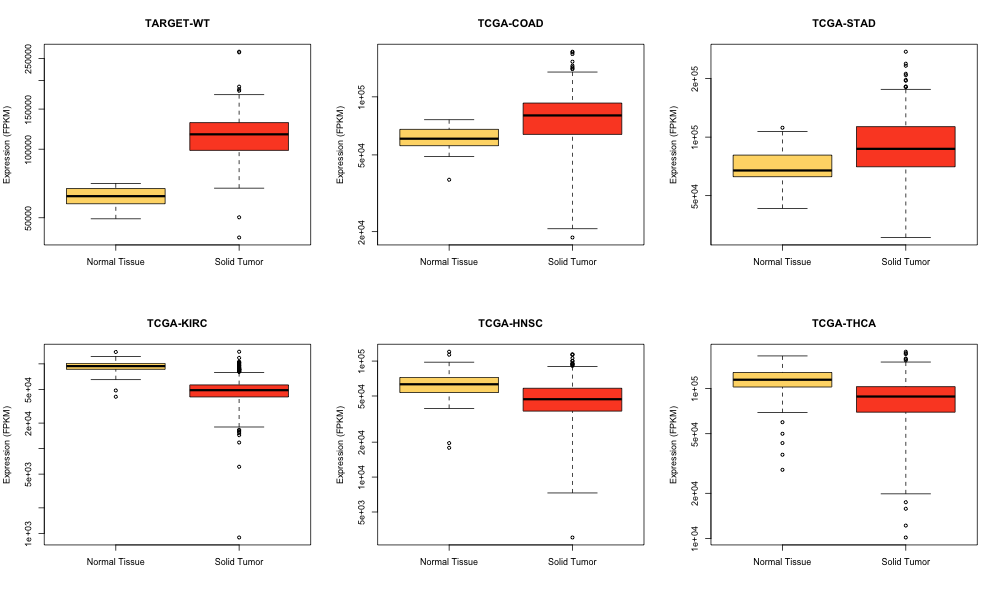

In [88]:
%%R -h 600 -w 1000
# Plot differential expression
par(mfrow=c(2, length(tumorTypes)/2), cex=0.75)
for (tumorType in tumorTypes) {
    plotDifferentialExpression(tumorType, 'NEK4', expressionData)
}

Finally, we investigate PKN3.

In [91]:
printDeseqResults('PKN3')

,baseMean,log2FoldChange,pvalue,padj
TCGA-THCA-primary_tumor_v_normal,686.518628,0.760438,1.064796e-33,3.136881e-32
TCGA-LIHC-primary_tumor_v_normal,460.660907,1.411283,1.141608e-22,3.113782e-21
TCGA-KICH-primary_tumor_v_normal,462.755770,-1.233080,2.668327e-20,3.585467e-19
TCGA-BRCA-primary_tumor_v_normal,707.666834,-0.683362,1.658509e-17,7.076287e-17
TCGA-KIRC-primary_tumor_v_normal,799.772633,0.640803,3.786645e-15,1.519703e-14
TCGA-COAD-primary_tumor_v_normal,481.260481,0.647785,1.915310e-06,5.508626e-06
TCGA-LUSC-primary_tumor_v_normal,701.329202,-0.501008,4.722974e-05,9.356092e-05
TCGA-LUAD-primary_tumor_v_normal,638.450334,-0.374535,9.977572e-05,2.188406e-04
TCGA-GBM-primary_tumor_v_normal,441.291983,1.089514,3.832228e-04,1.302475e-03
TCGA-STAD-primary_tumor_v_normal,1341.984595,0.518184,4.589343e-04,1.448394e-03


Similarly to NEK4, **PKN3** shows *varying patterns of differential expression* across TCGA tumor types - it is significantly overexpressed in Thyroid Carcinoma (THCA), Liver Hepatocellular Carcinoma (LIHC), and Kidney Renal Clear Cell Carcinoma (KIRC), among others; and significantly underexpressed in Kidney Chromophobe (KICH),  Breast Carcinoma (BRCA), and Lung Squamous Cell Carcinoma (LUSC), among others.

In [92]:
%%R
# Read expression data for selected tumor types
tumorTypes <- c('TCGA-THCA', 'TCGA-LIHC', 'TCGA-KIRC', 'TCGA-KICH', 'TCGA-BRCA', 'TCGA-LUSC')

# For plotting purposes, here we load the FPKM (Fragments per Kilobase per Million reads mapped) expression levels
expressionData <- sapply(tumorTypes, function(x) read.table(paste0(x, '/', x, '-fpkm-uq.txt'), row.names='gene_symbol', header=TRUE, sep='\t', check.names=FALSE))

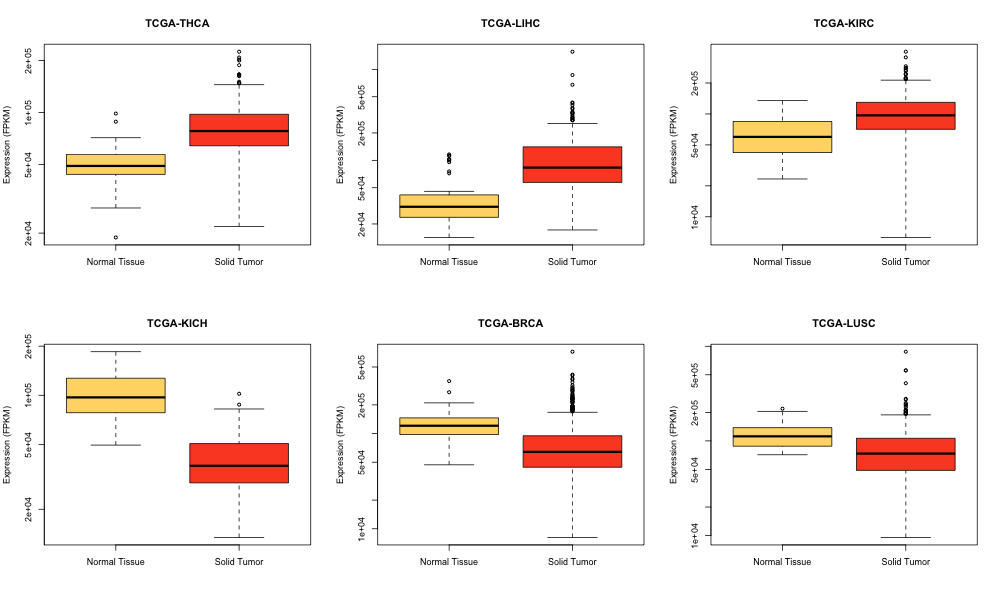

In [94]:
%%R -h 600 -w 1000
# Plot differential expression
par(mfrow=c(2, length(tumorTypes)/2), cex=0.75)
for (tumorType in tumorTypes) {
    plotDifferentialExpression(tumorType, 'PKN3', expressionData)
}

### References
- Michael I Love, Wolfgang Huber and Simon Anders (2014): Moderated
  estimation of fold change and dispersion for RNA-Seq data with
  DESeq2. Genome Biology
- Therneau T (2015). _A Package for Survival Analysis in S_. version
2.38,